In [6]:
import pandas as pd
import numpy as np
import os
from rich import print
import seaborn as sns

try:
    __SETUP
except:
    # if we are in the notebooks folder, go up one level
    path = os.getcwd()
    if path.endswith("solutions"):
        os.chdir("..")
    __SETUP = 1

print(os.getcwd())

/Users/andre/ergodic/tutai

In [57]:
data = pd.read_csv("data/vaccine.csv", index_col=0)
# vaccine is a binary variable, 0 means not vaccinated, 1 means vaccinated
# age is self explanatory
# hospitalized is a binary variable, 0 means not hospitalized, 1 means hospitalized
# gender is a binary variable, 1 means female, 0 means male
data.head(10)

,vaccine,age,gender,hospitalized
0,True,62,True,False
1,False,50,True,False
2,True,62,True,False
3,False,31,True,False
4,True,90,True,False
5,False,24,False,False
6,True,76,False,False
7,True,37,False,False
8,True,43,True,False
9,False,72,False,False


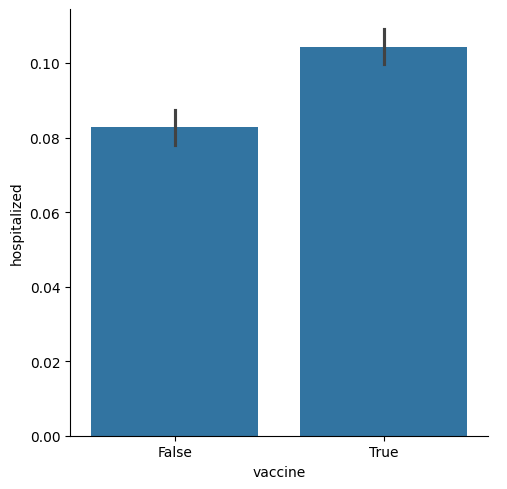

In [58]:
sns.catplot(data, x="vaccine", y="hospitalized", kind="bar")

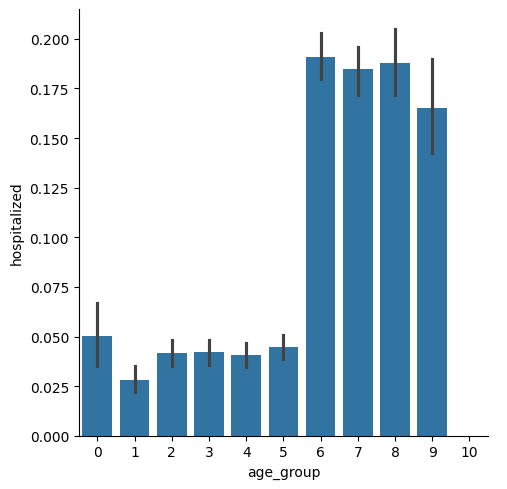

In [59]:
data["age_group"] = data["age"] // 10
sns.catplot(data, x="age_group", y="hospitalized", kind="bar")

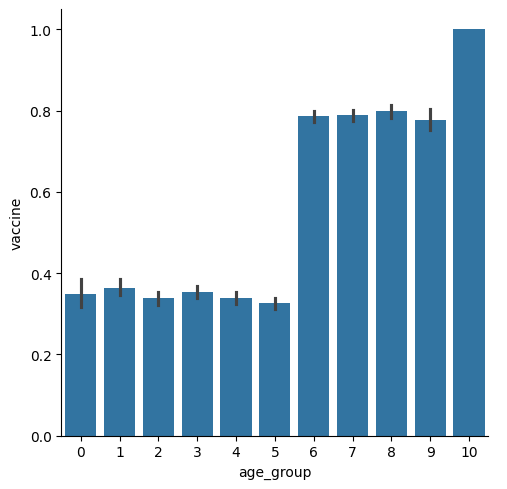

In [60]:
sns.catplot(data, x="age_group", y="vaccine", kind="bar")

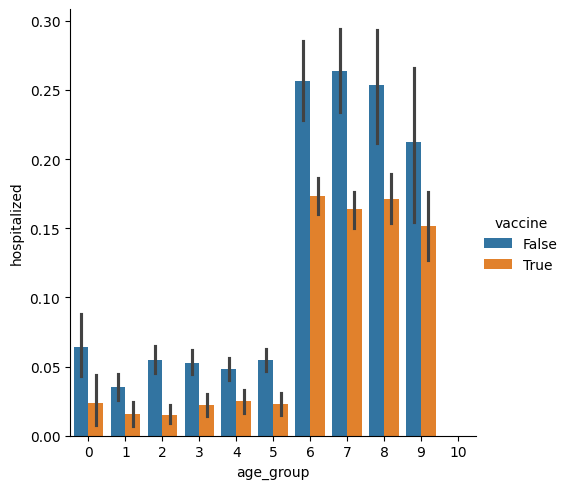

In [61]:
## What is really driving hospitalizations?
import seaborn as sns


sns.catplot(data, x="age_group", y="hospitalized", hue="vaccine", kind="bar")

Looks like something interesting is going on!

- Overall, people who get vaccinated are more likely to be hospitalized!
- Elderly people are more likely to get vaccinated.
- Elderly people are more likely to be hospitalized.
- At each age group, people who are vaccinated are less likely to be hospitalized.

# Simpson's paradox!

 <img src="../assets/simpsons.png" alt="Simpson's Paradox" style="max-width: 600px; max-height: 600px;">


**Propensity**: The likelihood or tendency of an individual to receive a particular treatment (like vaccination) based on their observable characteristics. In our vaccine example, elderly people have a higher propensity to get vaccinated because they are at higher risk.

**Confounding**: When a third variable influences both the treatment and the outcome, creating a spurious association between them or changing its structure. Age is a confounder here because it affects both vaccination rates (elderly get vaccinated more) and hospitalization rates (elderly are hospitalized more).


# The simplest thing we can do


Now, if you know one thing or two about econometrics, you know that the solution here is to somehow "control for" age in order to estimate the impact of vaccine on hospitalization. This is something known as a backdoor adjustment.

Econometricians will also quickly point out that all you need is to add "age" as a regression variable and your problems are solved (provided that about 314 conditions are met) - [FWL Theorem](https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem)

Let's try that and see what happens!


In [62]:
# We've quickly faced a problem: our target is categorical, not a regression, but let's close our eyes and pretend we didn't see that.

model = LogisticRegression()
model.fit(data[["age", "gender", "vaccine"]], data["hospitalized"])

# Convert logistic regression coefficient to probability change
# The coefficient for vaccine is model.coef_[0][2]
vaccine_coef = model.coef_[0][2]

# For logistic regression, we can approximate the marginal effect
# by multiplying the coefficient by p(1-p) where p is the mean probability
mean_prob = data["hospitalized"].mean()
marginal_effect = vaccine_coef * mean_prob * (1 - mean_prob)

print(f"Vaccine coefficient: {vaccine_coef:.3f}")
print(f"Approximate change in probability of hospitalization: {marginal_effect:.3f}")

Vaccine coefficient: -0.306

Approximate change in probability of hospitalization: -0.026

In [63]:
# Alternative approach: Calculate individual treatment effects by predicting outcomes
# for each person with and without vaccination

# Create copies of the data with vaccine set to True and False
data_vaccinated = data.copy()
data_vaccinated["vaccine"] = True

data_unvaccinated = data.copy()
data_unvaccinated["vaccine"] = False

# Predict probabilities for both scenarios
prob_vaccinated = model.predict_proba(data_vaccinated[["age", "gender", "vaccine"]])[
    :, 1
]
prob_unvaccinated = model.predict_proba(
    data_unvaccinated[["age", "gender", "vaccine"]]
)[:, 1]

# Calculate individual treatment effects
individual_effects = prob_vaccinated - prob_unvaccinated

# Average treatment effect
ate_individual = individual_effects.mean()

print(f"Average Treatment Effect (individual prediction method): {ate_individual:.3f}")

Average Treatment Effect (individual prediction method): -0.025

# Understanding propensity


The fundamental problem here is the following: There's a lot more elderly people getting vaccinated! And there's a lot more elderly people getting hospitalized.

The probability that a certain individual will be treated is called propensity - and our problem here is that our propensity correlates with the outcome.

What if we could try to "randomize" the data? I.e., we want to create a "synthetic sample" in which the "average weight" of those samples match between the treated and untreated group.

I.e.: suppose you're 20 years old and you got vaccinated - your contribution to the "pool of vaccinated" should matter a lot more than someone who's elderly.

On the converse, what if we look at the set of unvaccinated people and oversample those who are elderly.

With this idea, we can create a balanced dataset!

To do this, we do the following:

- We estimate the "propensity" of getting vaccinated. This tells us what's the probability that someone will be vaccinated, given their personal attributes.
- We sample based on that propensity.

This is called IPW - Inverse Probability Weighting!


In [64]:
from sklearn.linear_model import LogisticRegression

y = data["vaccine"]
X = data[["age", "gender"]]

# Let's use a simple logistic regression to estimate the propensity
model = LogisticRegression()
model.fit(X, y)


# Estimate propensity scores (probability of being vaccinated)
propensity_scores = model.predict_proba(X)[:, 1]  # probability of vaccine=True

# Calculate IPW weights
# For treated (vaccinated): weight = 1 / propensity_score
# For control (not vaccinated): weight = 1 / (1 - propensity_score)
weights = np.where(data["vaccine"], 1 / propensity_scores, 1 / (1 - propensity_scores))

In [65]:
print("Average age of vaccinated people: ", data[data["vaccine"]]["age"].mean())
print("Average age of unvaccinated people: ", data[~data["vaccine"]]["age"].mean())

print(
    "Weighted average age of vaccinated people: ",
    np.average(data[data["vaccine"]]["age"], weights=weights[data["vaccine"]]),
)
print(
    "Weighted average age of unvaccinated people: ",
    np.average(data[~data["vaccine"]]["age"], weights=weights[~data["vaccine"]]),
)

Average age of vaccinated people:  57.6210929756162

Average age of unvaccinated people:  42.415820273088045

Weighted average age of vaccinated people:  48.41145972037631

Weighted average age of unvaccinated people:  49.08854456766885

In [66]:
# Calculate IPW weights
# For treated (vaccinated): weight = 1 / propensity_score
# For control (not vaccinated): weight = 1 / (1 - propensity_score)
weights = np.where(data["vaccine"], 1 / propensity_scores, 1 / (1 - propensity_scores))

# Calculate weighted outcomes
treated_outcome = np.average(
    data[data["vaccine"]]["hospitalized"], weights=weights[data["vaccine"]]
)
control_outcome = np.average(
    data[~data["vaccine"]]["hospitalized"], weights=weights[~data["vaccine"]]
)

# Treatment effect (ATE - Average Treatment Effect)
treatment_effect = treated_outcome - control_outcome

print(f"Propensity-weighted hospitalization rate for vaccinated: {treated_outcome:.3f}")
print(
    f"Propensity-weighted hospitalization rate for unvaccinated: {control_outcome:.3f}"
)
print(f"Treatment effect (IPW estimate): {treatment_effect:.3f}")

Propensity-weighted hospitalization rate for vaccinated: 0.081

Propensity-weighted hospitalization rate for unvaccinated: 0.104

Treatment effect (IPW estimate): -0.024

# Keeping it real

So what if we just go ahead and stratify the data, and based on each strata, compare only neighbors to neighbors?

This is the basic idea of matching - while in this case it's a really really really simple matching, it can get quite complicated if you have multiple variables!


In [67]:
data["age_group"] = data["age"] // 10

unstacked = (
    data.groupby(["age_group", "vaccine"])["hospitalized"]
    .mean()
    .unstack(level="vaccine")
)

unstacked["effect"] = unstacked[True] - unstacked[False]
unstacked["count"] = data["age_group"].value_counts()

print(unstacked)

print(unstacked["effect"].mean())

vaccine       False      True    effect  count
age_group                                     
0          0.064516  0.024000 -0.040516    715
1          0.035368  0.015719 -0.019648   2269
2          0.055100  0.015179 -0.039922   3316
3          0.052836  0.022064 -0.030772   3979
4          0.048570  0.024782 -0.023788   4396
5          0.055015  0.022901 -0.032114   4422
6          0.256861  0.173146 -0.083715   4255
7          0.263946  0.163683 -0.100263   3472
8          0.253863  0.171141 -0.082722   2241
9          0.212560  0.151724 -0.060836    932
10              NaN  0.000000       NaN      3

-0.05142960890273927

In [68]:
unstacked["weighted_effect"] = unstacked["effect"] * unstacked["count"]
unstacked["weighted_effect"].sum() / unstacked["count"].sum()

np.float64(-0.05071174590901308)

# The fundamental problem of causal inference:

If we could clone everyone, send the clones to parallel universe and in that parallel universe give them a vaccine, our problem would be solved.

Unfortunately this isn't true, so we need to be creative.

What if instead, we try to do the following:

- Look at the group of people who have taken the vaccine. And only for that group, predict what's going to be their outcome using all the confounders available.
- Look at the control group, and predict their outcome using all the confunders as well.

- We take the estimated outcome as being the difference between the predicted outcomes of both these models.

Seems confusing, let's think step by step...


In [69]:
# T-learner implementation
# A T-learner trains separate models for treated and control groups

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [70]:
# Prepare features (age and gender)
X = data[["age", "gender"]].astype(float)
y = data["hospitalized"].astype(float)
treatment = data["vaccine"]

# Split data into treated and control groups
X_treated = X[treatment]
y_treated = y[treatment]
X_control = X[~treatment]
y_control = y[~treatment]

In [71]:
# Train separate models for each group

# What's happening here?
# We're creating two models, one that predicts the outcome for the treated group, and one that predicts the outcome for the control group.
model_treated = RandomForestClassifier(n_estimators=100, random_state=42)
model_control = RandomForestClassifier(n_estimators=100, random_state=42)

model_treated.fit(X_treated, y_treated)
model_control.fit(X_control, y_control)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
# MAGIC STEP:
# Predict outcomes for all individuals under both treatments
y_pred_treated = model_treated.predict_proba(X)[:, 1]
y_pred_control = model_control.predict_proba(X)[:, 1]

In [73]:
individual_treatment_effects = y_pred_treated - y_pred_control
ate_t_learner = individual_treatment_effects.mean()

print(f"T-learner Average Treatment Effect: {ate_t_learner:.3f}")
print(f"Standard deviation of ITEs: {individual_treatment_effects.std():.3f}")

T-learner Average Treatment Effect: -0.052

Standard deviation of ITEs: 0.069

In [76]:
# Compare with our previous estimates
print(f"\nComparison:")
print(f"T-learner ATE: {ate_t_learner:.3f}")
print(f"IPW ATE: {treatment_effect:.3f}")
print(
    f"Age-stratified ATE: {unstacked['weighted_effect'].sum() / unstacked['count'].sum():.3f}"
)

# Look at treatment effect heterogeneity by age
data["ite"] = individual_treatment_effects
age_groups = data.groupby("age_group")["ite"].agg(["mean", "std", "count"])
print(f"\nTreatment effect heterogeneity by age group:")
print(age_groups)

Comparison:

T-learner ATE: -0.052

IPW ATE: -0.024

Age-stratified ATE: -0.051

Treatment effect heterogeneity by age group:

mean       std  count
age_group                           
0         -0.037710  0.050337    715
1         -0.021190  0.031531   2269
2         -0.040193  0.023251   3316
3         -0.031498  0.019211   3979
4         -0.024457  0.029963   4396
5         -0.031773  0.022819   4422
6         -0.079738  0.075710   4255
7         -0.103946  0.052737   3472
8         -0.099286  0.152523   2241
9         -0.057523  0.133513    932
10        -0.242658  0.000000      3

In [75]:
# Congratulations, you're close to the cutting edge of causal inference!
# https://arxiv.org/pdf/1706.03461

# What we covered here

1. The question of "what will happen to Y if I change X" is actually quite nuanced and requires some thinking.
2. We learned about confounding, and how "controlling for" a confounder is very important
3. Once we've identified a good set of covariates, how to build simple estimators to tell us the impact of these interventions.
4. The notion of ATE and ITE.

Follow-up question:

- How do we know which variables to select? Can I just throw all of them in?
